# Create and train a model from scratch !

- toc: true

## What will we do ?
We will create a *linear* model then a *neural network* from scratch to do *binary classification*, train them using *gradient descent* and finally see how current libraries sipmlify these things for us and we'll create our own class that mimicks the tools provided by these libraries.

> If you never used *Pytorch* before, i would refer you to my other post [Start simple, start with a baseline !](https://igrek-code.github.io/blog/2020/11/01/start-simple-start-with-a-baseline.html), which gives a more gentle introduction to the tools needed here.

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

     |████████████████████████████████| 727kB 4.6MB/s 
     |████████████████████████████████| 1.1MB 24.2MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 194kB 41.6MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 40kB 7.5MB/s 
     |████████████████████████████████| 92kB 11.6MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 2.6MB 37.4MB/s 


## Getting and preparing the data (you can skip this part)

We'll be using the *MNIST_SAMPLE* dataset provided by *fastai*, which contains images of 3's and 7's.

We start by downloading the data, opening the images, turning them into tensors and stacking them into a rank-3 tensors (matrix) for each label (train/valid) separately.

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
three_train = torch.stack([tensor(Image.open(o)).float()/255 for o in (path/'train'/'3').ls()])
seven_train = torch.stack([tensor(Image.open(o)).float()/255 for o in (path/'train'/'7').ls()])
seven_valid = torch.stack([tensor(Image.open(o)).float()/255 for o in (path/'valid'/'7').ls()])
three_valid = torch.stack([tensor(Image.open(o)).float()/255 for o in (path/'valid'/'3').ls()])

Then, we'll concatenate 3/7 tensors obtained (train/ valid seperately) into one single tensor and flatten the images out by reshaping the tensors. 

For our independant variables we'll create the corresponding tensor, with 1 indicating a 3 and 0 indicating a 7. Add a dimension, to not have problems further down the road (due to broadcasting).

In [3]:
train_x = torch.cat([three_train, seven_train]).view(-1, 28*28)
train_y = tensor([1] * len(three_train) + [0] * len(seven_train)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [4]:
valid_x = torch.cat([three_valid, seven_valid]).view(-1, 28*28)
valid_y = tensor([1] * len(three_valid) + [0] * len(seven_valid)).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

Create our **dataset** (for PyTorch it is a list of tuples containing our dependant/ independant variables).

Then create our **dataloader**, which is obtained by shuffling the **dataset**, and creating batches of size 256.

And wrap that in a *Dataloaders* object.

In [5]:
dset = list(zip(train_x, train_y))
dl = DataLoader(dset, batch_size=256, shuffle=True)
dset_valid = list(zip(valid_x, valid_y))
dl_valid = DataLoader(dset_valid, batch_size=256, shuffle=True)
dls = DataLoaders(dl, dl_valid)

## Create and train the model

### 1. From scratch approach

Okay, now that we've done the kinda "boring" part, let's dive into our subject of interest.

To assess how good our model is (human consumption), we'll need to define a *metric*.

In [6]:
def batch_accuracy(predictions, targets):
    return ((predictions > 0) == targets).float().mean()

Now we also need to define a loss function, that we will optimize using SGD.

In [7]:
def mnist_loss(predictions, targets):
  result = predictions.sigmoid()
  return torch.where(targets == 1, 1 - result , result).mean()

Where's the model at ? No worries, he's just here waiting for you !

> In python "**@**" refers to matrix multiplication.

In [8]:
def linear(xb): return xb @ w + b

Something to randomly initialize the parameters with. And initialize them.

In [9]:
def init_params(*size): return (torch.randn(size)).requires_grad_()
w, b = init_params(28*28, 1), init_params(1) 

We need a training loop that corresponds to the graph below. So let's do just that.

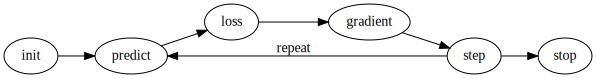

In [ ]:
#hide_input
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [ ]:
# Number of epochs
epochs = 5
# setting the learning rate
lr = 1
# Training loop
for i in range(epochs):
  for xb, yb in dls[0]:
    # Predict
    result = linear(xb)
    # Calculate the loss
    loss = mnist_loss(result, yb)
    # Calculate the gradient
    loss.backward()
    # Take a step
    w.data -= w.grad * lr
    b.data -= b.grad * lr

    # Set the gradient to zero, s the next time we calculate it, it doesn't accumulate
    w.grad.zero_()
    b.grad.zero_()
  # Show the batch accuracy for each epoch
  print(tensor([batch_accuracy(linear(xb), yb) for xb, yb in dls[1]]).mean().item(), end=' ')

0.9121212959289551 0.9434308409690857 0.9494490027427673 0.9557371139526367 0.9602308869361877 

Now let's scale up a bit, and go for the neural net.
Which will consist of two linear layers (first and last) and one non-linearity between them (Which in this case is the rectified linear unit).

In [10]:
def simple_net(xb):
  result1 = xb @ w1 + b1 
  result2 = F.relu(result1)
  return result2 @ w2 + b2

In [11]:
w1, b1 = init_params(28*28, 30), init_params(30)
w2, b2 = init_params(30, 1), init_params(1)

We'll be using the same training loop, but since it's a more "complex" model, we'll lower the learning rate and train for more epochs. So we'll just show the accuracy for the last epoch.

In [ ]:
# Number of epochs
epochs = 40
# setting the learning rate
lr = 0.1
# Training loop
for i in range(epochs):
  for xb, yb in dls[0]:
    # Predict
    result = simple_net(xb)
    # Calculate the loss
    loss = mnist_loss(result, yb)
    # Calculate the gradient
    loss.backward()
    # Take a step
    w1.data -= w1.grad * lr
    b1.data -= b1.grad * lr
    w2.data -= w2.grad * lr
    b2.data -= b2.grad * lr

    # Set the gradient to zero, s the next time we calculate it, it doesn't accumulate
    w1.grad.zero_()
    b1.grad.zero_()
    w2.grad.zero_()
    b2.grad.zero_()

# Show the batch accuracy for the last epoch
print(tensor([batch_accuracy(simple_net(xb), yb) for xb, yb in dls[1]]).mean().item(), end=' ')

0.953414797782898 

### 2. Using existing tools

Okay, but all of what we've done so far can already be implemented using *fastai2* and *PyTorch* using just these lines of code.

In [ ]:
# Create the model, same neural network as above (it will also initialize the params)

simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

# Create the Learner object

learn = Learner(dls, simple_net, loss_func=mnist_loss, opt_func=SGD, metrics=batch_accuracy)

# Train the model

learn.fit(40, lr = 0.1)

As you can see we create a **Learner** object, it's a class that handles all the training process for you, you just give it five things:

- Your dataloaders object.
- The model.
- The loss function to optimize.
- The optimization function.
- The metrics to be displayed (Optionnal).

> The optimization function (Optimizer) in *PyTorch* is a function that handles the gradient step for you, e.g. updating the params and setting the gradient to zero.

In [ ]:
# Create the optimizer

opt = SGD(simple_net.parameters(), 0.1) # we give it the params and learning rate

Let's try to mimik this by creating our own **Learner** class from scratch.

In [20]:
class MyLearner:

  # Initializing the learner

  def __init__(self, dls, model, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy): 
    self.dls = dls 
    self.model = model 
    self.opt_func = opt_func 
    self.loss_func = loss_func 
    self.metrics = metrics

    # We store the metric values in a list (to plot them for example)
    self.metric_values = []

  # Method for training our model

  def fit(self, epochs, lr=1):

    # Create the optimizer
    opt = self.opt_func(self.model.parameters(), lr)

    # Training loop (same as before)
    for i in range(epochs):
        for xb, yb in self.dls[0]:
          result = self.model(xb)
          loss = self.loss_func(result, yb)
          loss.backward()

          # We update the weights using our optimizer
          opt.step()

          # Setting the gradient to zero using the same optimizer
          opt.zero_grad()

        # Calculate the metric value, store it and print it for each epoch  
        b_accuracy = tensor([self.metrics(self.model(xb), yb) for xb, yb in self.dls[1]]).mean().item()
        self.metric_values.append(b_accuracy)
        print(round(b_accuracy, 4), end=' ')

Let's try it for a simple linear model. IT WORKS !!!

0.9706 0.9749 0.977 0.9779 0.9784 0.9789 0.9794 0.9808 0.9793 0.9798 0.9803 0.9803 0.9813 0.9808 0.9813 0.9814 0.9823 0.9829 0.9823 0.9824 

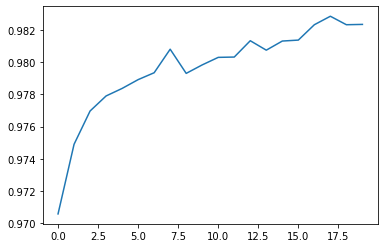

In [26]:
# Create a MyLearner object
my_learner = MyLearner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

# Train it
my_learner.fit(20)

# Plot the metric values with each epoch
plt.plot(my_learner.metric_values);